# Proceso de análisis de datos sobre MNIST con GPT4o y otras exploraciones

En este proyecto, exploraremos el conjunto de datos de MNIST utilizando distintas técnicas de exploración de datos y la asistencia de GPT4o. Posteriormente, entrenaremos un modelo simple utilizando Pytorch. Finalmente evaluaremos el desempeño del modelo, analizando sus errores y su desempeño en datos no vistos previamente.

Durante el proceso, demostraremos la importancia de la exploración y el entendimiento de los datos, ya que esto puede darnos pistas clave para encontrar posibles problemas ocultos en procesos posteriores.

En este notebook veremos un modelo que consigue un desempeño muy bueno, pero, durante la fase de inferencia, parece comportarse como si no hubiera entrenado en lo absoluto, disminuyendo su precisión de casi el 100% a menos del 20% a pesar de que los datos de la inferencia parecen bastante similares a los datos originales de MNIST a simple vista.

Veremos por qué ocurre esto, los motivos subyacentes y sus posibles soluciones


## Indice

1. [Carga de datos y exploración inicial](#1.-Carga-de-datos-y-exploración-inicial)
2. [Análisis Exploratorio de Datos (EDA) con GPT4o](#2.-Análisis-Exploratorio-de-Datos-(EDA)-con-GPTo)
    1. [Distribución de las clases](#2.1.-Distribución-de-las-clases)
    2. [Valores de los Pixeles](#2.2.-Valores-de-los-Pixeles)
    3. [Promedio y desviación estándar](#2.3.-Promedio-y-desviación-estándar)
    4. [Correlación de pixeles](#2.4.-Correlación-de-pixeles)
    5. [Análisis estadístico](#2.5.-Análisis-estadístico)
    6. [Análisis de similitud: Dividiendo en clusters](#2.6.-Análisis-de-similitud:-Dividiendo-en-clusters)
    7. [Análisis de similitud 2: PCA vs t-SNE](#2.7.-Análisis-de-similitud-2:-PCA-vs-t-SNE)
3. [Entrenamiento del modelo simple](#3.-Entrenamiento-del-modelo-simple)
    1. [Definir estructura de la red](#3.1.-Definir-estructura-de-la-red)
    2. [Preprocesar datos](#3.2.-Preprocesar-datos)
    3. [Configurar DataLoaders](#3.3.-Configurar-DataLoaders)
    4. [Configurar dispositivo de computación](#3.4.-Configurar-dispositivo-de-computación)
    5. [Definir modelo, función de loss y optimizador](#3.5.-Definir-modelo,-función-de-loss-y-optimizador)
    6. [Entrenar modelo](#3.6.-Entrenar-modelo)
4. [Evaluar Modelo](#4.-Evaluar-Modelo)
    1. [Visualizar activaciones](#4.1.-Visualizar-activaciones)
    2. [Identificando outliers y errores](#4.2.-Identificando-outliers-y-errores)
5. [Guardar el modelo](#5.-Guardar-el-modelo)
6. [Proceso de inferencia sobre datos no vistos](#6.-Proceso-de-inferencia-sobre-datos-no-vistos)
    1. [Exploración del problema más a fondo](#6.1.-Exploración-del-problema-más-a-fondo)
7. [Conclusiones Finales](#7.-Conclusiones-finales)

In [4]:
# Importaciones
from collections import Counter
from random import randint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
from fastai.vision.all import *
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min
from torch import optim
from torchvision import transforms

## 1. Carga de datos y exploración inicial

In [5]:
# Cargando los datos
path = untar_data(URLs.MNIST)
train_path = path/'training'
test_path = path/'testing'

In [6]:
def show_img_samples(n_class, num_images=9):
    """
    Muestra una cuadrícula de ejemplos de imágenes de la clase especificada.

    Args:
    -----
    n_class (int): Dígito de la clase a visualizar (0-9).
    num_images (int): Número de imágenes a mostrar.
    """
    # Obtener rutas de las imágenes para la clase seleccionada
    image_paths = train_path.ls().sorted()[n_class].ls()
    # Seleccionar imagenes aleatorias
    sample_imgs = random.sample(image_paths, num_images)

    # Calcular el número de filas y columnas
    rows = int(math.sqrt(num_images))
    cols = int(math.ceil(num_images / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten() if num_images > 1 else [axes]  # Manejar caso de una sola imagen
    
    # Crear cuadrícula
    for ax, img_path in zip(axes, sample_imgs):
        img = Image.open(img_path)
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    # Ocultar ejes no usados
    for ax in axes[len(sample_imgs):]:
        ax.axis('off')
    
    plt.suptitle(f'Clase {n_class}: Ejemplos')
    plt.show()

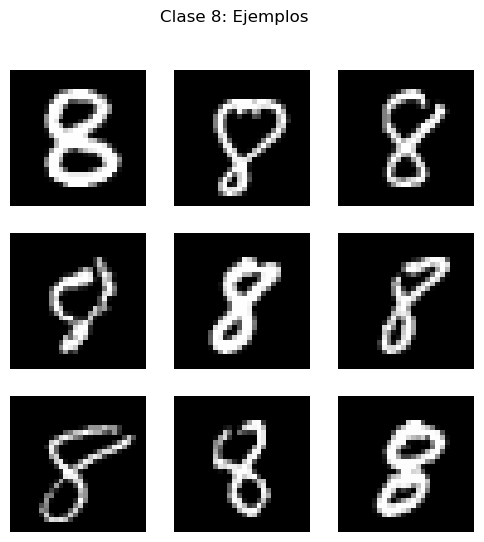

In [9]:
show_img_samples(randint(0, 9), 9)

Con esta visualicación realizamos una primera toma de contacto con los datos, gracias a esto podemos:
- Comprobar que los datos están bien etiquetados.
- Comprobar que los datos no tienen anomalías visibles.
- Entender de un vistazo rápido las variaciones dentro de una misma clase.

Todos estos puntos son importantes para tenerlos en cuenta a la hora de diseñar nuestros futuros modelos.

En este caso en particular, observamos lo siguiente:
- Podemos observar distintas características clave dentro de una misma clase: Alteraciones en tamaños y formas de los dígitos, variaciones en el estilo y orientación del trazo, e incluso variaciones en el grosor de este.
- La calidad de las imágenes es buena y consistente, a simple vista no observamos etiquetas erroneas, tampoco apreciamos anomalías evidentes.
- Existe un buen contraste entre el fondo y el dígito. Lo que facilita el entendimiento de la imagen.
- Tenemos algunos estilos de escritura tan peculiares que podrían llegar a ser ambiguos con respecto al dígito que representan.

## 2. Análisis Exploratorio de Datos (EDA) con GPT4o

Para esta fase no he estado sólo, me he servido de la ayuda de GPT4o para conseguir un análisis efectivo. El enfoque tomado ha sido un enfoque iterativo:

1. Brainstorming inicial con los pasos a seguir en el proyecto sin influencia del modelo.
2. Segundo brainstorming con la revisión del modelo sobre mi brainstorming inicial para conseguir nuevas ideas.
3. Definir la estructura de los pasos a seguir en el análisis exploratorio.
4. Crear un prompt a partir de la estructura de pasos obtenida, especificando el tipo de asistencia que busco, las limitaciones y añadiendo contexto necesario.
5. Especificar al modelo que recorra los pasos de manera iterativa, enfocándose en uno por vez, y haciendo pausas para discutir el paso y analizar los resultados para retocar tanto la consulta inicial como la estructura del análisis, con posibilidad de profundizar en sub-análisis potencialmente interesantes.

**Nota:** Antes de estos pasos, he instruido al modelo con la idea del proyecto y los objetivos, así como el enfoque que quería tomar, para conseguir orientarlo lo máximo posible a lo que busco.

La consulta para ejecutar el análisis exploratorio paso a paso es la siguiente:

```markdown
__CONSULTA__
Profundiza en el análisis exploratorio de los datos para mi proyecto siguiendo el plan que hemos estructurado previamente.

__CONTEXTO__

- Debes considerar la etapa actual del proyecto, la estructura y el formato de mis datos. A partir de esto profundizaremos en el análisis.

Estructura de los pasos profundizar:
---
- Paso 1; Distribución de clases: Crearemos un gráfico de barras para visualizar distribución de imágenes de cada clase, comparando las distribuciones del conjunto de entrenamiento y de prueba.
- Paso 2; Valores de píxels: Visualizar historigramas de valores de píxels para cada clase, visualizando distribución de intensidades de pixeles para la identificación de anomalías o patrones.
- Paso 3; Promedio y desviación estándar: Calcularemos y visualizaremos las imágenes promedio y la desviación estándar para cada clase, con el objetivo de compararlas posteriormente entre sí.
- Paso 4; Correlación de píxeles: Crearemos mapas de calor para visualizar la correlación de píxeles entre distintas imágenes.
- Paso 5; Análisis estadístico: Calcularemos las estadísticas descriptivas (media, mediana y desviación estándar) de los valores de los pixeles y las compararemos entre sí.
- Paso 6; Análisis de Similitud: Utilizaremos técnicas de clustering para agrupar imágenes similares y visualizar los datos. Usaremos PCA para la reducción de dimensionalidad.
- Paso 7; Análisis de Similitud 2: Repetiremos el paso previo, pero esta vez usando la técnica t-SNE, y compararemos ambos métodos.
---

- Para cada uno de los pasos debes incluir las siguientes áreas áreas:
    - Importancia del paso para el análisis.
    - Ejemplo de código necesario para el paso, bien estructurado y comentado.
    - 3 ideas de posibles sub-análisis para profundizar en el paso.
 
- Cuando completes el paso esperarás que te comparta los resultados para analizarlos.
- Cuando te comparta los resultados, discutiremos los puntos interesantes del paso y responderás mis preguntas hasta que te especifique que continuemos con el siguiente paso.

__LIMITACIONES__
- Mantén tu respuesta limpia y bien estructurada en formato markdown, con cabeceros bien diferenciados.
- Usa un formato de bullet list para presentar tus ideas de forma clara y concisa.
- Mantén tus respuestas breves, extiéndete lo justo para comunicar las ideas clave de forma efectiva.
- No incluyas introducciones, conclusiones ni otro tipo de aclaraciones, debes centrarte en los pasos.
- IMPORTANTE: Debes centrarte en un paso por respuesta, discutiremos ese paso y nos enfocaremos en ese hasta que yo te diga que continuemos con el siguiente.
```


### 2.1. Distribución de las clases

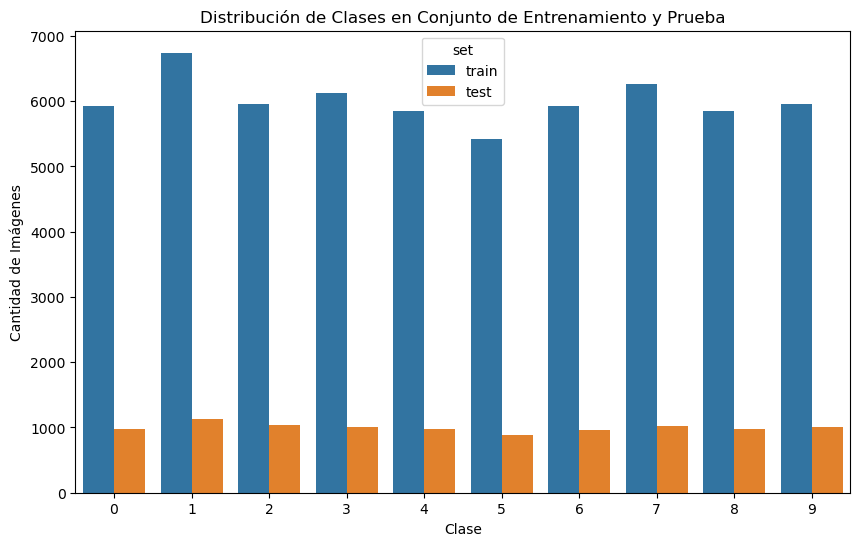

In [51]:
# Contar la cantidad de imágenes en cada clase para entrenamiento y prueba
train_counter = Counter([p.parent.name for p in train_path.ls().sorted().map(lambda x: x.ls()).concat()])
test_counter = Counter([p.parent.name for p in test_path.ls().sorted().map(lambda x: x.ls()).concat()])

# Crear un dataframe para las distribuciones
train_df = pd.DataFrame.from_dict(train_counter, orient='index', columns=['count'])
train_df['set'] = 'train'
test_df = pd.DataFrame.from_dict(test_counter, orient='index', columns=['count'])
test_df['set'] = 'test'
dist_df = pd.concat([train_df, test_df]).reset_index().rename(columns={'index': 'class'})

# Visualizar la distribución de clases
plt.figure(figsize=(10, 6))
sns.barplot(x='class', y='count', hue='set', data=dist_df)
plt.title('Distribución de Clases en Conjunto de Entrenamiento y Prueba')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Imágenes')
plt.show()

Gracias a este análisis podríamos ver si tenemos desbalances entre las clases. En este caso se aprecia como la distribución es bastante equilibrada.

En el caso de tener un desbalance significativo, podríamos optar por ejecutar técnicas de re-muestreo o cambiar la estrategia tomada con los datos.

### 2.2. Valores de los Pixeles

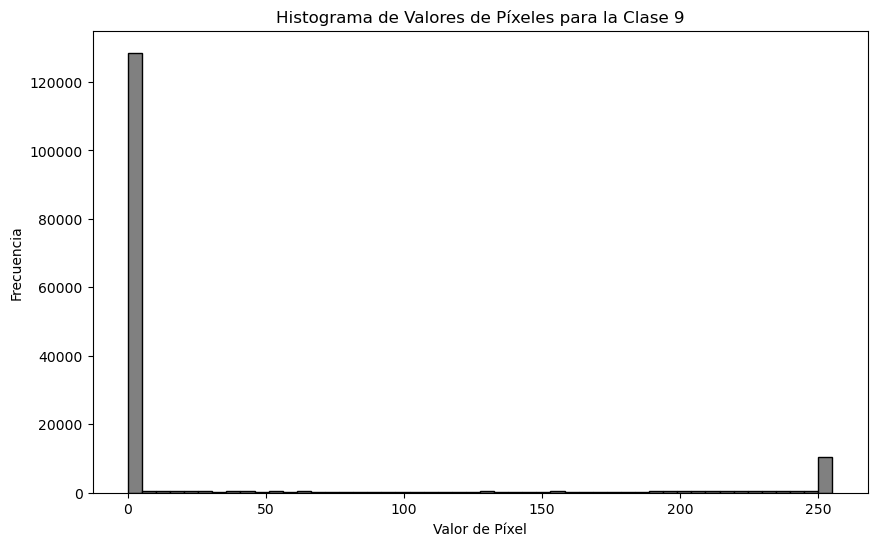

In [52]:
def show_pixel_hist(train_path, n_class, num_images=200):
    """
    Visualiza histogramas de valores de píxeles para una clase específica.
    
    Args:
    -----
    train_path (PosixPath): Ruta de las carpeta de imágenes de entrenamiento.
    n_class (int): La clase de dígitos a visualizar (0-9).
    num_images (int): Número de imágenes a considerar para el histograma.
    """
    # Obtener rutas de las imágenes para la clase seleccionada
    image_paths = train_path.ls().sorted()[n_class].ls()

    # Establecer límite de imagenes
    img_amount = len(image_paths)
    if num_images > img_amount:
        num_images = img_amount
    
    # Seleccionar aleatoriamente imágenes
    selected_images = random.sample(image_paths, num_images)
    
    # Acumular valores de píxeles
    pixel_values = []
    for img_path in selected_images:
        img = Image.open(img_path)
        pixel_values.extend(np.array(img).flatten())
    
    # Crear histograma de valores de píxeles
    plt.figure(figsize=(10, 6))
    plt.hist(pixel_values, bins=50, color='gray', edgecolor='black')
    plt.title(f'Histograma de Valores de Píxeles para la Clase {n_class}')
    plt.xlabel('Valor de Píxel')
    plt.ylabel('Frecuencia')
    plt.show()

# Visualizar histograma
show_pixel_hist(train_path,9)

Aquí podemos ver algo interesante; la distribución de los pixeles está bastante bien definida en dos valores principalmente: 0 (el fondo negro) y 255 (el trazo del dígito). Esto puede parecer obvio, pero más adelante veremos como este conocimiento es clave para determinadas situaciones.

Podemos ver además algunos valores de pixeles menos significativos entre el 1 y el 254. Estos valores representan el contorno del trzazo de los dígitos, que tiene un tono de gris más claro u oscuro. También podrían representar ruido en algunas imágenes. Podríamos llegar a considerar usar alguna técnica de filtrado para eliminar estos valores intermedios y quedarnos con el trazo más puro y ver cómo influye en el desempeño de nuestros modelos.

Esta visualización nos permite además, identificar potencialmente valores de pixeles atípicos, indicando posibles problemas de calidad, etiquetados incorrectos u outliers. Esta información nos podría guiar en las técnicas de normalización o ajuste de contraste que decidamos aplicar más adelante.

### 2.3. Promedio y desviación estándar

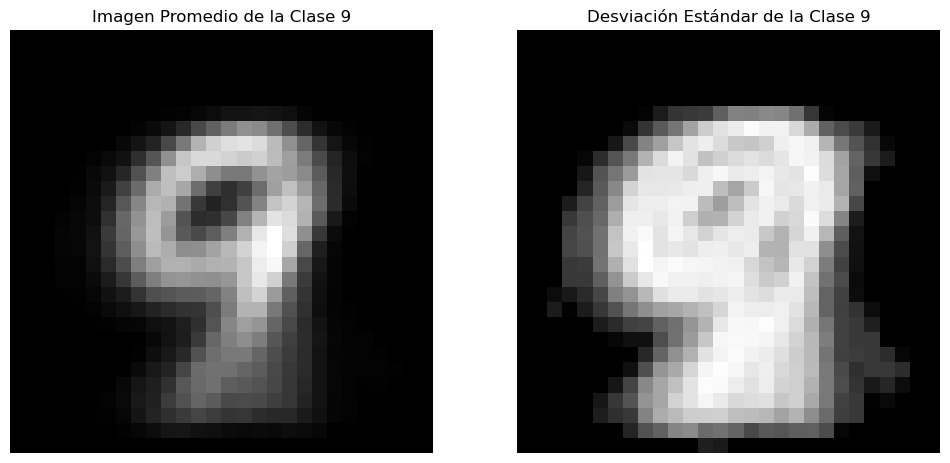

In [53]:
def show_mean_std(train_path, n_class, num_images=100):
    """
    Calcula y visualiza la imagen promedio y la desviación estándar para una clase específica.
    
    Args:
    train_path (PosixPath): Ruta de las carpeta de imágenes de entrenamiento.
    clase (int): La clase de dígitos a analizar (0-9).
    num_images (int): Número de imágenes a considerar para el cálculo.
    """
    # Obtener rutas de las imágenes para la clase seleccionada
    image_paths = train_path.ls().sorted()[n_class].ls()
    
    # Seleccionar rutas de imágenes aleatoriamente
    selected_images = random.sample(image_paths, num_images)
    
    # Acumular valores de píxeles en una lista
    pixel_values = []
    for img_path in selected_images:
        img = Image.open(img_path)
        pixel_values.append(np.array(img))
    
    # Convertir la lista en un array 3D (num_images, height, width)
    pixel_array = np.stack(pixel_values)
    
    # Calcular la imagen promedio y la desviación estándar
    mean_img = np.mean(pixel_array, axis=0)
    std_img = np.std(pixel_array, axis=0)
    
    # Visualizar la imagen promedio
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(mean_img, cmap='gray')
    plt.title(f'Imagen Promedio de la Clase {n_class}')
    plt.axis('off')
    
    # Visualizar la desviación estándar
    plt.subplot(1, 2, 2)
    plt.imshow(std_img, cmap='gray')
    plt.title(f'Desviación Estándar de la Clase {n_class}')
    plt.axis('off')
    
    plt.show()

# Visualizar resultados
show_mean_std(train_path, 9)

Gracias a este análisis, podemos entender mejor la variabilidad y consistencia dentro de cada una de las clases.

**Imagen promedio**
- Nos permite encontrar patrones y características que se repiten dentro de una misma clase.
- Podemos ver información interesante sobre la forma y estructura de las imágenes, en este caso, las características principales de cada dígito.
- Las características más comunes entre clases estarán representadas con valores de pixeles más altos, mientras que las más variables tendrán una mayor borrosidad, esto suele ocurrir en los bordes, que es donde suele influir más el tipo de trazo.
- Tomando como ejemplo la clase '9', podemos ver cómo sus características principales serían la cabeza redondeada y la cola, sin embargo, podemos apreciar como la cabeza es más clara, y la cola presenta un mayor difuminado, principalmente porque es donde más variaciones hay en este dígito.

**Desviación estándar**
- Nos permite encontrar áreas de alta variabilidad dentro de cada clase, que puedan suponer un problema potencial para nuestros modelos.
- Las zonas con pixeles más sólidos son en las que se centralizan la mayor cantidad de coincidencias, mientras que las borrosas, o con tonos de pixeles intermedios muestran las zonas menos consistentes.

Algo común a todas las clases en este caso es una mayor consistencia en las regiones centrales, con desviaciones más pronunciadas hacia los bordes. Confirmando el conocimiento obtenido de análisis previos.

Gracias a este análisis podemos ver claramente características únicas de cada clase, ayudando a plantear una estrategia para el entrenamiento de nuestro modelo con mayor claridad.

En este caso, podemos ver que la clase con una mayor consistencia es el 0.


### 2.4. Correlación de pixeles

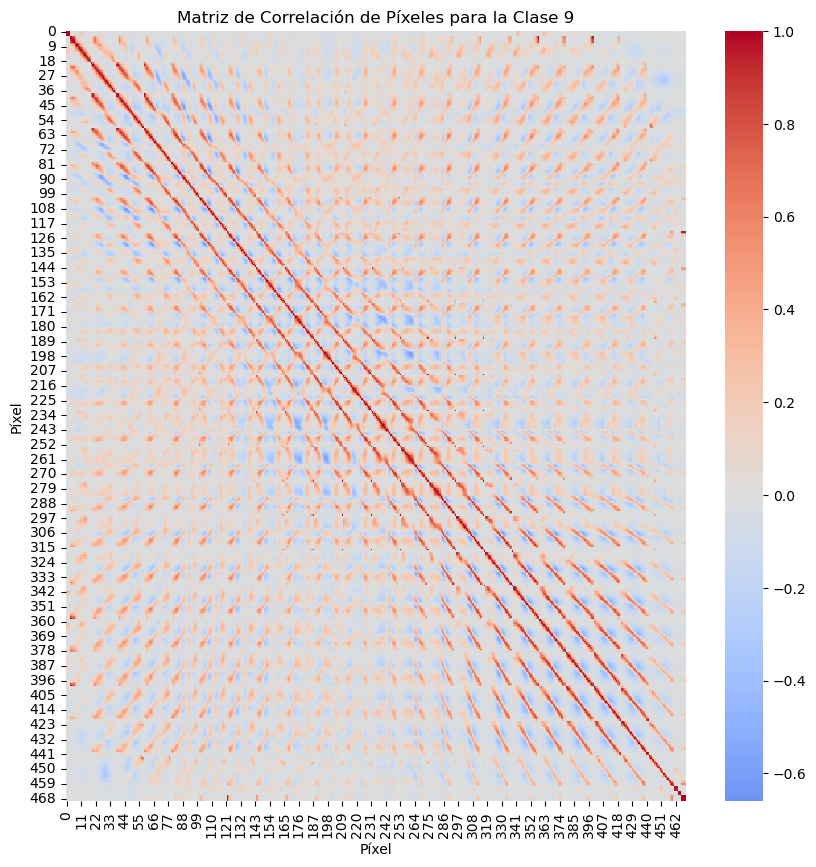

In [54]:
def show_pixel_corr(train_path, n_class, num_images=500):
    """
    Calcula y visualiza la correlación de píxeles para una clase específica.
    
    Args:
    train_path (PosixPath): Ruta de las carpeta de imágenes de entrenamiento.
    n_class (int): La clase de dígitos a analizar (0-9).
    num_images (int): Número de imágenes a considerar para el cálculo.
    """
    # Obtener rutas de las imágenes para la clase seleccionada
    image_paths = train_path.ls().sorted()[n_class].ls()
    
    # Seleccionar rutas de imágenes aleatoriamente
    selected_images = random.sample(image_paths, num_images)
    
    # Acumular valores de píxeles en una lista
    pixel_values = []
    for img_path in selected_images:
        img = Image.open(img_path)
        pixel_values.append(np.array(img))
    
    # Convertir la lista en un array 2D (num_images, num_pixeles)
    pixel_array = np.stack(pixel_values)
    
    # Filtrar columnas con desviación estándar cero
    std_dev = np.std(pixel_array, axis=0)
    non_zero_std_mask = std_dev > 0
    pixel_array_filtered = pixel_array[:, non_zero_std_mask]
    
    # Calcular la matriz de correlación
    correlacion = np.corrcoef(pixel_array_filtered, rowvar=False)
    
    # Visualizar la matriz de correlación
    plt.figure(figsize=(10, 10))
    sns.heatmap(correlacion, cmap='coolwarm', center=0)
    plt.title(f'Matriz de Correlación de Píxeles para la Clase {n_class}')
    plt.xlabel('Píxel')
    plt.ylabel('Píxel')
    plt.show()

# Visualizar correlación de pixeles
show_pixel_corr(train_path, 9)


Gracias a esta visualización podemos ver si los pixeles de las imágenes tienen algún tipo de correlación. Esto podría servirnos por ejemplo para ejecutar técnicas de reducción de dimensionalidad, simplificando los datos sin perder información significativa.

En este caso, lo que podemos apreciar es lo siguiente:

- La diagonal central que va de izquierda-arriba hacia derecha-abajo indica que los pixeles están correlacionados positivamente entre sí, es decir, cuando un pixel en una imagen tiene un valor alto dentro de una clase, el mismo pixel en el resto de imágenes suelen tener un valor alto.
- Las diagonales secundarias paralelas a la diagonal central indica que los pixeles abyacentes a los pixeles con alta correlación suelen estar correlacionados también.
- La variabilidad de las correlaciones fuera de la diagonal principal, puede sugerir los distintos estilos de escritura y trazo, que es lo que afecta a estas correlaciones.

### 2.5. Análisis estadístico

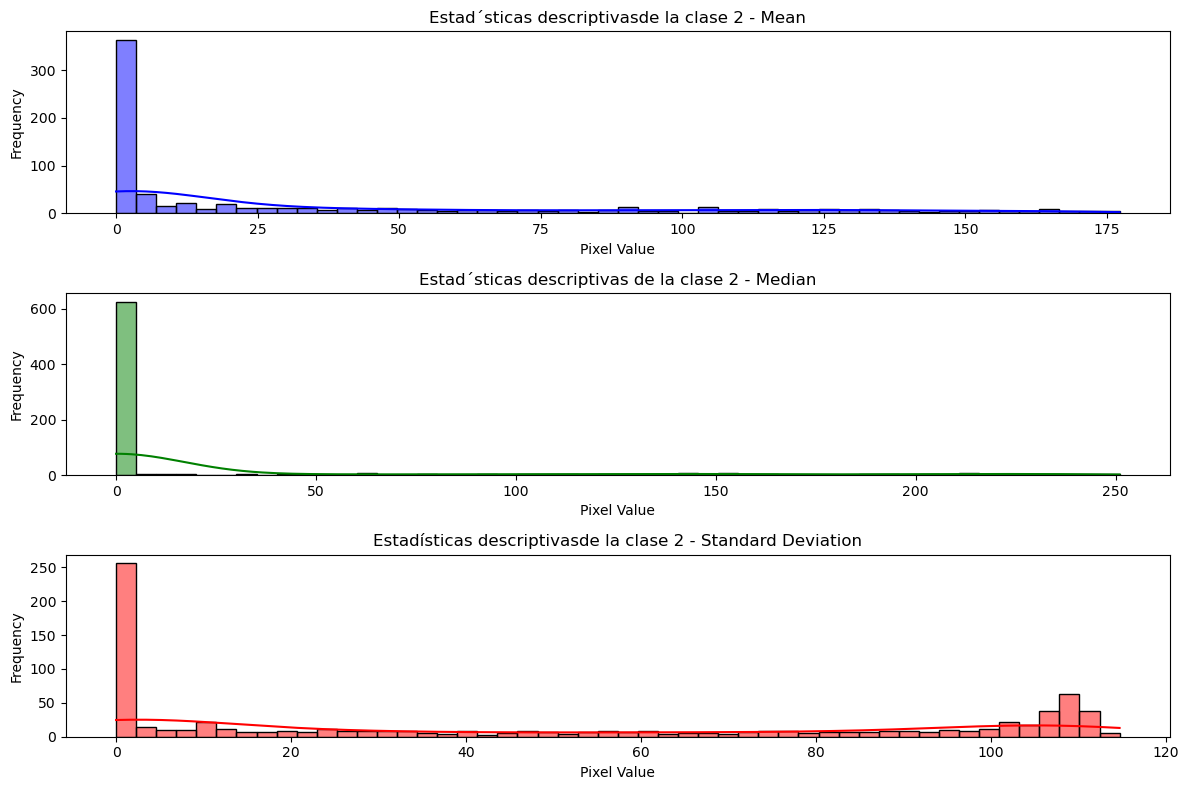

In [10]:
def show_pixel_stats(train_path, n_class, num_images=600):
    """
    Calcula y visualiza las estadísticas descriptivas (media, mediana, desviación estándar)
    de los valores de los píxeles para una clase específica.
    
    Args:
    train_path (PosixPath): Ruta de las carpeta de imágenes de entrenamiento.
    n_class (int): La clase de dígitos a analizar (0-9).
    num_images (int): Número de imágenes a considerar para el cálculo.
    """
    # Obtener rutas de las imágenes para la clase seleccionada
    image_paths = train_path.ls().sorted()[n_class].ls()
    
    # Seleccionar rutas de imágenes aleatoriamente
    selected_images = random.sample(image_paths, num_images)
    
    # Acumular valores de píxeles en una lista
    pixel_values = []
    for img_path in selected_images:
        img = Image.open(img_path)
        pixel_values.append(np.array(img).flatten())
    
    # Convertir la lista en un array 2D (num_images, num_pixeles)
    pixel_array = np.stack(pixel_values)
    
    # Calcular estadísticas descriptivas
    mean, median, std_dev = np.mean(pixel_array, axis=0), np.median(pixel_array, axis=0), np.std(pixel_array, axis=0)
    
    # Crear un DataFrame para facilitar la visualización
    stats_df = pd.DataFrame({
        'Mean': mean,
        'Median': median,
        'Standard Deviation': std_dev
    })
    
    # Parámetros para los gráficos
    stats_names = ['Mean', 'Median', 'Standard Deviation']
    colors = ['blue', 'green', 'red']
    titles = [
        f'Estadísticas descriptivas de la clase {n_class} - Promedio',
        f'Estadísticas descriptivas de la clase {n_class} - Mediana',
        f'Estadísticas descriptivas de la clase {n_class} - Desviación estándar'
    ]
    
    # Visualizar las estadísticas descriptivas
    plt.figure(figsize=(12, 8))
    
    for i, (stat, color, title) in enumerate(zip(stats_names, colors, titles), start=1):
        plt.subplot(3, 1, i)
        sns.histplot(stats_df[stat], bins=50, kde=True, color=color)
        plt.title(title)
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Visualizar estadísticas descriptivas
show_pixel_stats(train_path, 2)

Esto nos permite ver de una forma más visual y clara las distribuciones de los valores de pixeles dentro de cada clase.

En este caso, podemos ver lo siguiente:
- Tenemos un gran pico de valores en 0, lo que señala el fondo negro de las imágenes.
- La desviación estándar podemos verla ligeramente más dispersa que la mediana y la media.

### 2.6. Análisis de similitud: Dividiendo en clusters

In [63]:
# Función para cargar y preparar los datos
def load_and_prepare_data(train_path, num_images=1000, random_state=42):
    """
    Carga y prepara los datos de imágenes del conjunto de datos MNIST.
    
    Args:
    train_path (PosixPath): Ruta de las carpeta de imágenes de entrenamiento.
    num_images (int): Número de imágenes a considerar para el análisis.
    
    Returns:
    all_image_paths (list): Lista de rutas de imágenes.
    pixel_array (np.array): Array 2D de valores de píxeles (num_images, num_pixeles).
    """
    # Establecer seed para reproducibilidad
    np.random.seed(random_state)
    random.seed(random_state)
    
    # Obtener todas las rutas de imágenes de todas las clases
    all_image_paths = []
    all_labels = []
    for i in range(10):
        image_paths = train_path.ls().sorted()[i].ls()
        selected_images = random.sample(image_paths, min(num_images // 10, len(image_paths)))
        all_image_paths.extend(selected_images)
        all_labels.extend([i] * len(selected_images))

    # Acumular valores de píxeles en una lista
    pixel_values = []
    for img_path in all_image_paths:
        img = Image.open(img_path)
        pixel_values.append(np.array(img).flatten())
    
    # Convertir la lista en un array 2D (num_images, num_pixeles)
    pixel_array = np.stack(pixel_values)
    
    return all_image_paths, pixel_array, all_labels


In [71]:
def perform_clustering(pixel_array, num_clusters=10, random_state=42):
    """
    Realiza el clustering en los datos proporcionados.
    
    Args:
    pixel_array (np.array): Array 2D de valores de píxeles (num_images, num_pixeles).
    num_clusters (int): Número de clusters para el algoritmo de clustering.
    random_state (int): Semilla para el generador de números aleatorios para reproducibilidad.
    
    Returns:
    reduced_data (np.array): Datos reducidos utilizando PCA.
    labels (np.array): Etiquetas de los clusters asignados por K-Means.
    """
    # Reducir la dimensionalidad utilizando PCA
    pca = PCA(n_components=50, random_state=random_state)
    reduced_data = pca.fit_transform(pixel_array)

    # Aplicar K-Means Clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state)
    kmeans.fit(reduced_data)
    labels = kmeans.labels_
    
    return reduced_data, labels

In [72]:
def visualize_clusters(reduced_data, labels):
    """
    Visualiza los clusters utilizando los datos reducidos.
    
    Args:
    reduced_data (np.array): Datos reducidos utilizando PCA.
    labels (np.array): Etiquetas de los clusters asignados por K-Means.
    """
    # Visualizar los clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
    plt.title('Clustering de Imágenes de Todas las Clases')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    plt.show()

In [73]:
def show_cluster_examples(all_image_paths, labels, num_images=5, num_clusters=10, random_state=42):
    """
    Visualiza ejemplos de imágenes de cada cluster para todas las clases.
    
    Args:
    all_image_paths (list): Lista de rutas de imágenes.
    labels (np.array): Etiquetas de los clusters asignados por K-Means.
    num_images (int): Número de imágenes a visualizar por cluster.
    num_clusters (int): Número de clusters.
    """
    # Establecer seed para reproducibilidad
    np.random.seed(random_state)
    random.seed(random_state)
    
    # Visualizar ejemplos de imágenes de cada cluster
    fig, axes = plt.subplots(num_clusters, num_images, figsize=(15, 3*num_clusters))
    for cluster in range(num_clusters):
        cluster_indices = np.where(labels == cluster)[0]
        cluster_images = random.sample(list(cluster_indices), min(num_images, len(cluster_indices)))
        for i, idx in enumerate(cluster_images):
            img = Image.open(all_image_paths[idx])
            axes[cluster, i].imshow(img, cmap='gray')
            axes[cluster, i].axis('off')
            axes[cluster, i].set_title(f'Cluster {cluster}', fontsize=10)
    
    plt.suptitle(f'Ejemplos de Imágenes por Cluster - Todas las Clases', size='xx-large', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Aumentar el espacio para el título
    plt.show()

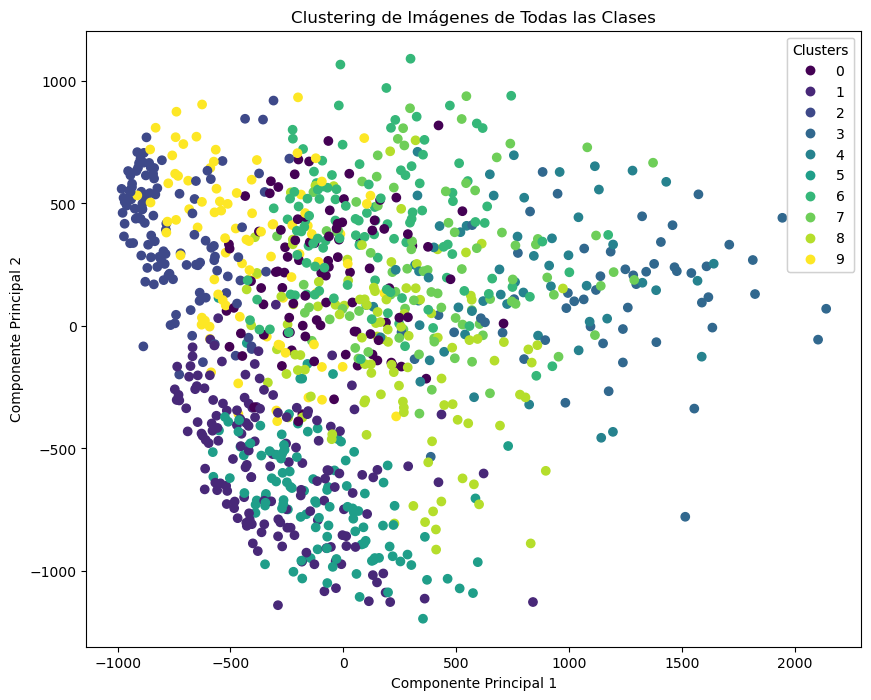

In [74]:
# Cargar y preparar los datos
all_image_paths, pixel_array, all_labels = load_and_prepare_data(train_path)

# Realizar el clustering
reduced_data, labels = perform_clustering(pixel_array)

# Visualizar los clusters
visualize_clusters(reduced_data, labels)

Cada punto de este gráfico representa una imagen, y su color el cluster al que pertenece.

Los puntos cercanos en el gráfico son aquellas imágenes que tienen características similares, según lo definido por el cluster, es decir, las imágenes son agrupadas basándose en las características que el algoritmo de clustering (K-Means) considera más importantes a la hora de diferenciar los grupos. Estas características son derivadas de la reducción de dimensionalidad realizada por PCA, que nos ayuda a capturar gran parte parte de la variabilidad de los datos.

Para hacernos una idea más en profundidad de lo que estamos viendo, vamos a visualizar ejemplos de los clusters.

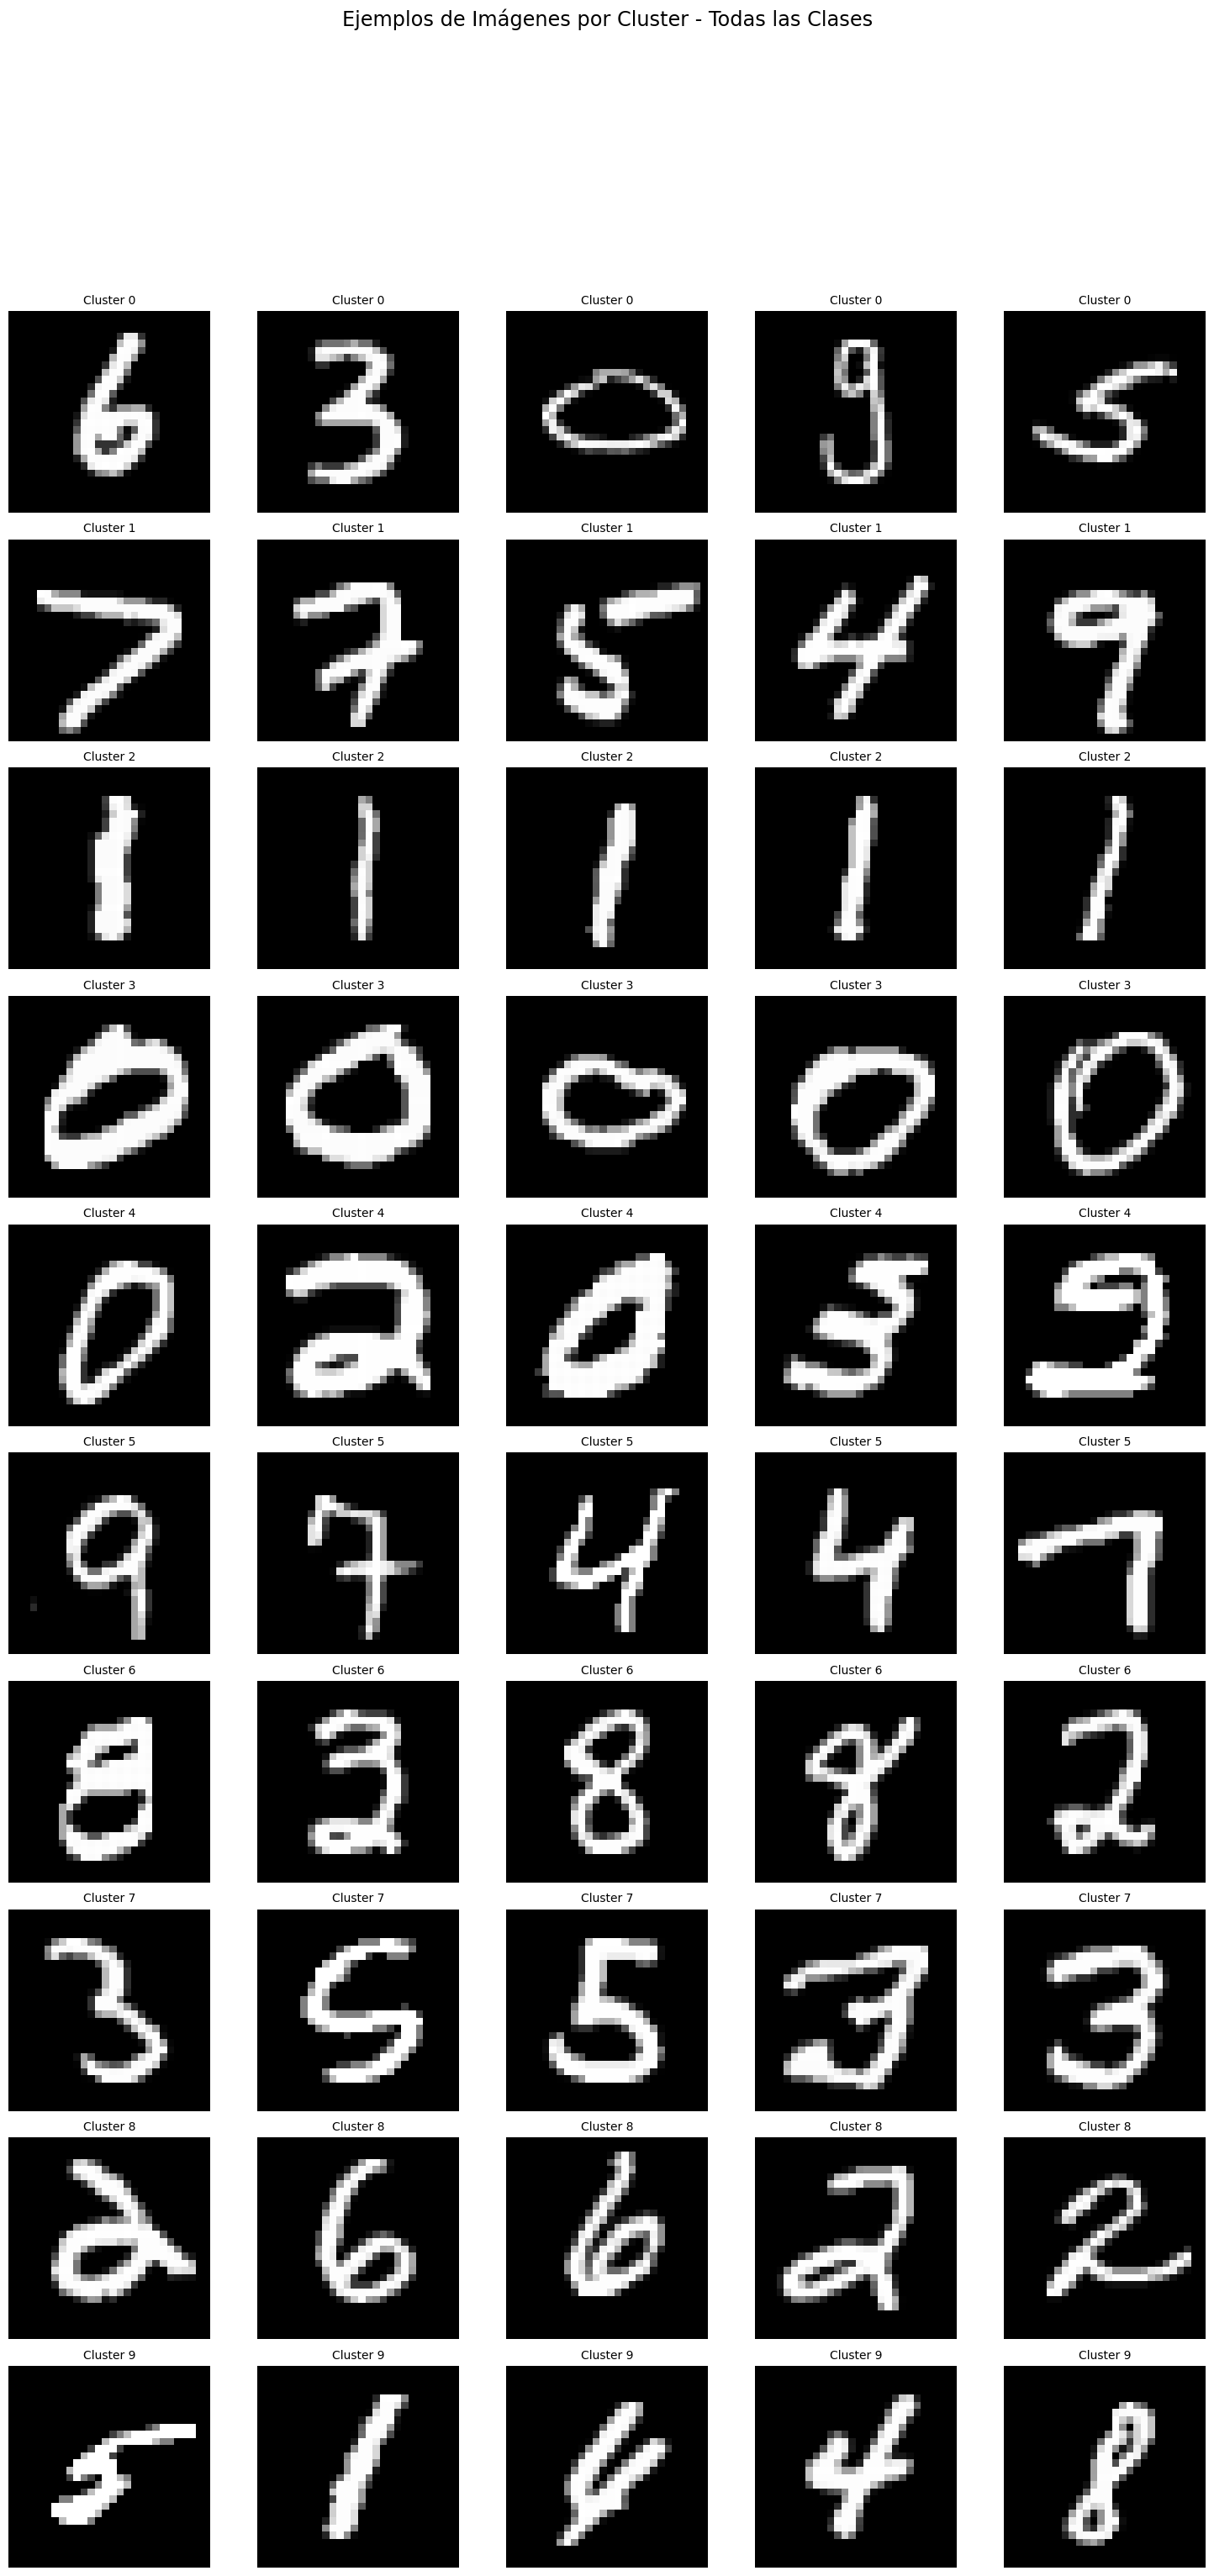

In [75]:
# Mostrar ejemplos de imágenes de cada cluster
show_cluster_examples(all_image_paths, labels)

A simple vista podemos ver cómo el algoritmo ha capturado algunas características comunes en los dígitos, pero parece que está lejos de tener un buen desempeño.

Podríamos probar a realizar algunos cambios para ver cómo afecta al desempeño y los clusters, por ejemplo, podríamos usar otra técnica de reducción de la dimensionalidad como t-SNE, cambiar el número de clusters, usar otro algoritmo de cloustering o aumentar la cantidad de componentes.

### 2.7. Análisis de similitud 2: PCA vs t-SNE

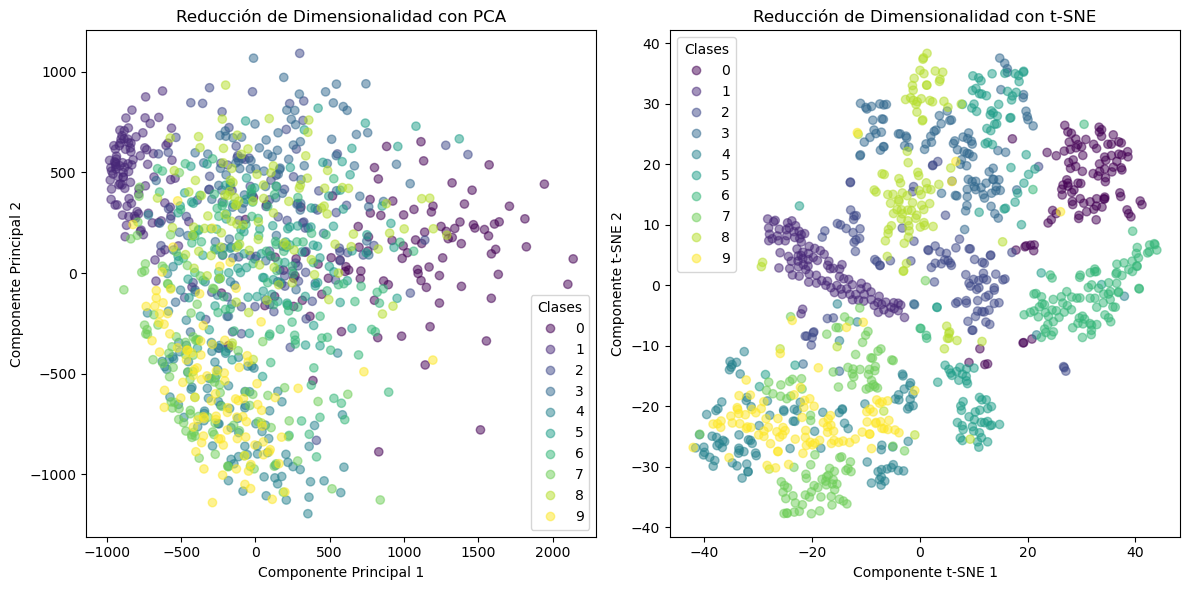

In [76]:
def compare_dimensionality_reduction(train_path, num_images=1000, random_state=42):
    """
    Realiza un análisis de similitud utilizando PCA y t-SNE para todas las clases.
    
    Args:
    train_path (PosixPath): Ruta de las carpeta de imágenes de entrenamiento.
    num_images (int): Número de imágenes a considerar para el análisis.
    random_state (int): Semilla para el generador de números aleatorios para reproducibilidad.
    """
    # Cargar y preparar los datos
    all_image_paths, pixel_array, all_labels = load_and_prepare_data(train_path, num_images, random_state)
    
    # Reducir la dimensionalidad utilizando PCA
    pca = PCA(n_components=50, random_state=random_state)
    reduced_data_pca = pca.fit_transform(pixel_array)
    
    # Aplicar t-SNE para mayor reducción de dimensionalidad
    tsne = TSNE(n_components=2, random_state=random_state)
    reduced_data_tsne = tsne.fit_transform(reduced_data_pca)
    
    # Visualizar los datos reducidos por PCA
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    scatter_pca = plt.scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1], c=all_labels, cmap='viridis', alpha=0.5)
    plt.title('Reducción de Dimensionalidad con PCA')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend(handles=scatter_pca.legend_elements()[0], labels=list(range(10)), title="Clases")

    # Visualizar los datos reducidos por t-SNE
    plt.subplot(1, 2, 2)
    scatter_tsne = plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=all_labels, cmap='viridis', alpha=0.5)
    plt.title('Reducción de Dimensionalidad con t-SNE')
    plt.xlabel('Componente t-SNE 1')
    plt.ylabel('Componente t-SNE 2')
    plt.legend(handles=scatter_tsne.legend_elements()[0], labels=list(range(10)), title="Clases")

    plt.tight_layout()
    plt.show()

# Realizar el análisis de similitud utilizando PCA y t-SNE para todas las clases
compare_dimensionality_reduction(train_path, num_images=1000, random_state=42)

Como vemos, t-SNE muestra una separación más clara entre las distintas clases.

## 3. Entrenamiento del modelo simple

Para el entrenamiento del modelo vamos a seguir los siguientes pasos:
1. Definir la estructura de la red neuronal.
2. Preparar los datos para el modelo.
3. Realizar configuraciones previas para la efectividad del entrenamiento del modelo.
4. Definir modelo y sus parámetros.
5. Entrenar modelo.

### 3.1. Definir estructura de la red 

In [79]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Capas del modelo
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        # Aplanar la entrada
        x = x.view(-1, 28*28)
        # Aplicar funciones de activación
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Crear una instancia del modelo
model = SimpleNN()
print(model)

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


### 3.2. Preprocesar datos

Para este paso, vamos a normalizar las imágenes para tener valores de pixeles consistentes, y convertirlas en tensores para que puedan procesarse mejor por parte de Pytorch.

In [87]:
# Definiendo las transformaciones que aplicaremos en la normalización
transform = transforms.Compose([
    transforms.ToTensor(), # Convertimos las imágenes a tensores
    transforms.Normalize((0.5,), (0.5,)) # Aplicamos normalización
    ])

In [88]:
# Cargamos los conjuntos de datos de entrenamiento y prueba
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transform, 
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    transform=transform, 
    download=True
)

In [90]:
train_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

### 3.3. Configurar DataLoaders

Los DataLoaders hacen que el proceso de entrenamiento sea eficiente y nos aseguran que el modelo recibe los datos en lotes.

In [91]:
# Creamos DataLoader para los conjuntos de datos
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=64, 
    shuffle=True # Mezclamos para evitar sesgos en el entrenamiento
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=64, 
    shuffle=False
)

### 3.4. Configurar dispositivo de computación

Verificar que estamos usando la GPU.

In [92]:
# Verificar si hay GPU disponible y usarla; de lo contrario, usar CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cuda


### 3.5. Definir modelo, función de loss y optimizador

In [95]:
# Definir el modelo
model = SimpleNN().to(device) # Movemos al modelo al dispositivo utilizado

# Definir dunción de loss
criterion = nn.CrossEntropyLoss()

# Definir el optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f'Modelo:\n{model}\n\nFunción de loss:\n{criterion}\n\nOptimizador:\n{optimizer}')

Modelo:
SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Función de loss:
CrossEntropyLoss()

Optimizador:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


### 3.6. Entrenar modelo

In [96]:
num_epochs = 5

# Bucle de entrenamiento
for epoch in range(num_epochs):
    model.train() # Establecer el modelo en modo de entrenamiento
    running_loss = 0.0

    for images, labels in train_loader:
        # Mover imágenes y etiquetas al dispositivo
        images, labels = images.to(device), labels.to(device)

        # Foward prop
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward prop
        optimizer.zero_grad() # Limpiar gradientes
        loss.backward() # Calcular gradientes
        optimizer.step() # Actualizar weights

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
print('Entrenamiento completado')

Epoch [1/5], Loss: 0.3917
Epoch [2/5], Loss: 0.1876
Epoch [3/5], Loss: 0.1383
Epoch [4/5], Loss: 0.1096
Epoch [5/5], Loss: 0.0957
Entrenamiento completado


## 4. Evaluar Modelo

In [110]:
def evaluate_model(model, data_loader, device):
    """
    Evalúa el modelo en el conjunto de datos de prueba y devuelve la precisión.

    Args:
    model (nn.Module): El modelo de red neuronal.
    data_loader (DataLoader): DataLoader para el conjunto de datos de prueba.
    device (torch.device): El dispositivo en el que se ejecuta el modelo.

    Returns:
    float: La precisión del modelo en el conjunto de datos de prueba.
    """
    model.eval()  # Establecer el modelo en modo evaluación

    correct = 0
    total = 0

    with torch.no_grad():  # Desactivar cálculo de gradientes
        for images, labels in data_loader:
            # Mover imágenes y etiquetas al dispositivo
            images, labels = images.to(device), labels.to(device)

            # Forward propagation
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calcular precisión
    accuracy = 100 * correct / total
    return accuracy

accuracy = evaluate_model(model, test_loader, device)
print(f'Accuracy del modelo en la evaluación: {accuracy:.2f}%')

Accuracy del modelo en la evaluación: 96.26%


### 4.1. Visualizar activaciones

In [102]:
def get_layer_activations(model, data_loader, layer, device):
    """
    Obtiene las activaciones de una capa específica del modelo para los datos de entrada.

    Args:
    model (nn.Module): El modelo de red neuronal.
    data_loader (DataLoader): DataLoader para los datos que se van a visualizar.
    layer (str): Nombre de la capa cuyas activaciones se van a visualizar.
    device (torch.device): El dispositivo en el que se ejecuta el modelo.

    Returns:
    activations (numpy.ndarray): Activaciones de la capa específica.
    labels (numpy.ndarray): Etiquetas reales correspondientes a las activaciones.
    """
    model.eval()  # Establecer el modelo en modo de evaluación
    activations = []
    labels = []

    with torch.no_grad():  # Desactivar cálculo de gradientes
        for images, lbls in data_loader:
            images = images.to(device)
            if layer == 'fc1':
                outputs = model.fc1(images.view(-1, 28*28))
            elif layer == 'fc2':
                outputs = model.fc2(F.relu(model.fc1(images.view(-1, 28*28))))
            activations.append(outputs.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    activations = np.concatenate(activations)
    labels = np.concatenate(labels)
    return activations, labels

In [104]:
def visualize_layer_activations(model, data_loader, layer, device, random_state=42):
    """
    Visualiza las activaciones de una capa específica del modelo utilizando t-SNE.

    Args:
    model (nn.Module): El modelo de red neuronal.
    data_loader (DataLoader): DataLoader para los datos que se van a visualizar.
    layer (str): Nombre de la capa cuyas activaciones se van a visualizar.
    random_state (int): Semilla para el generador de números aleatorios para reproducibilidad.
    device (torch.device): El dispositivo en el que se ejecuta el modelo.
    """
    # Obtener activaciones y etiquetas
    activations, labels = get_layer_activations(model, data_loader, layer, device)

    # Reducir dimensionalidad de las activaciones usando t-SNE
    tsne = TSNE(n_components=2, random_state=random_state)
    activations_2d = tsne.fit_transform(activations)

    # Visualizar las activaciones reducidas
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(activations_2d[:, 0], activations_2d[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, ticks=range(10))
    plt.title(f'Visualización de Activaciones de {layer} con t-SNE')
    plt.xlabel('Componente t-SNE 1')
    plt.ylabel('Componente t-SNE 2')
    plt.show()

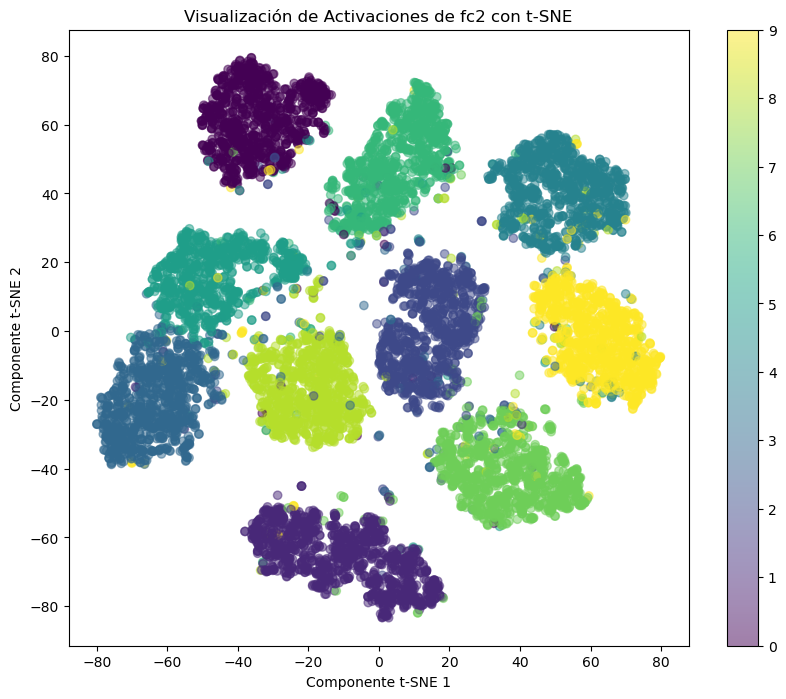

In [105]:
# Visualizar activaciones para la segunda capa
visualize_layer_activations(model, test_loader, 'fc2', random_state=42, device=device)

Podemos sacar algunas conclusiones a partir de visualizar las activaciones de esta capa:

- Por las separaciones claras de los clusters, podemos decir que el modelo ha aprendido las características distintivas de cada clase de dígitos. Las capas del modelo parecen capturar bien las diferencias entre clases.
- Tenemos algunas superposiciones en algunos dígitos, como el 4 y el 9, lo que puede indicar que el modelo ve estas clases más difíciles de separar. Pueden ser áreas de interés a tener en cuenta para mejorar el modelo.
- El 1 y el 0 son las clases que tienen los clusters mejor definidos. Esto indica que las activaciones internas para estos dígitos están bien definidas y diferenciadas. Estos dígitos tienen formas distintas y consistentes para el modelo.
- El tamaño o forma de estos clusters puede indicar la variabilidad dentro de las clases. Los dígitos en los que hay mayor variabilidad de estilo de escritura pueden formar clusters más amplios o dispersos, mientras que los clusters más compactos sugieren menor variabilidad y una representación más coherente de ese dígito.

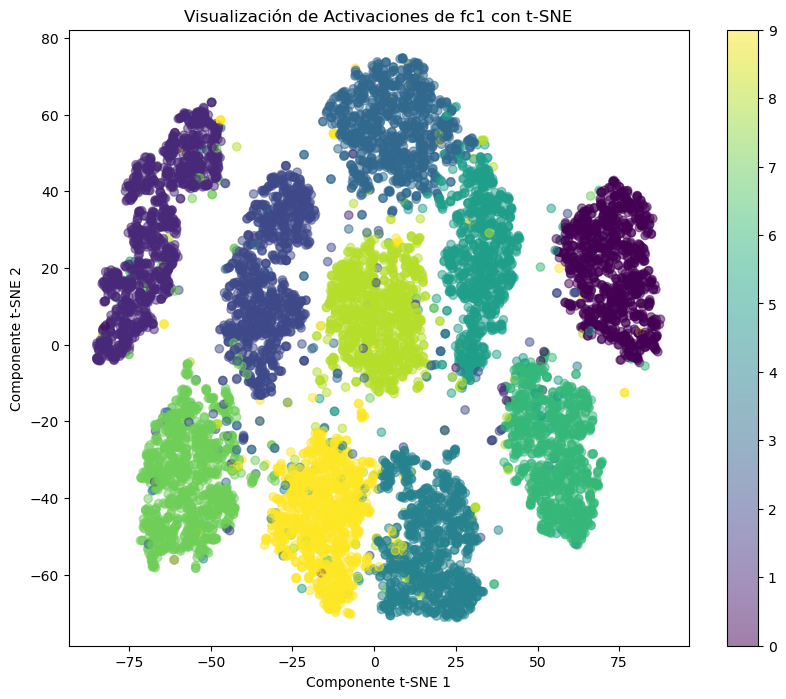

In [106]:
# Visualizar activaciones para la primera capa
visualize_layer_activations(model, test_loader, 'fc1', random_state=42, device=device)

Al visualizar la primera capa podemos ver que, a pesar de la simpleza del modelo, desde este punto ya empezaba a distinguir bastante bien las distintas clases. Sin embargo, también podemos observar cómo existe una mayor dispersión y variabilidad intra-clase; en la segunda capa podíamos ver grupos más compactos.

### 4.2. Identificando outliers y errores

Vamos a visualizar algunos de los errores del modelo, aquellos en los que tiene mayor confianza y aun así está equivocado.

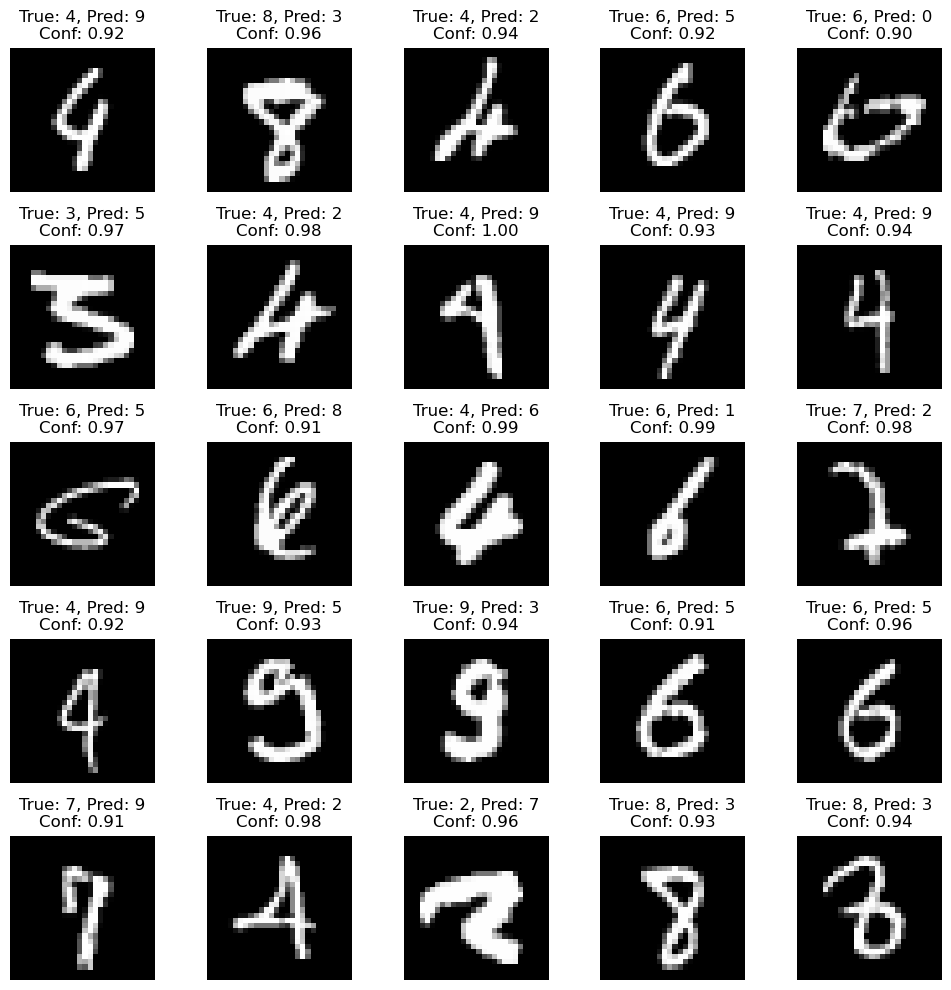

In [107]:
def identify_outliers(model, data_loader):
    """
    Identifica outliers y errores de predicción con alta confianza.

    Args:
    model (nn.Module): El modelo de red neuronal.
    data_loader (DataLoader): DataLoader para los datos de prueba.

    Returns:
    outliers (list): Lista de outliers identificados.
    """
    model.eval()
    outliers = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            predicted = torch.argmax(probabilities, dim=1)
            confidence = torch.max(probabilities, dim=1)[0]
            
            for i in range(len(labels)):
                if predicted[i] != labels[i] and confidence[i] > 0.9:  # Umbral de alta confianza
                    outliers.append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu(), confidence[i].cpu()))
    
    return outliers

# Identificar outliers en el conjunto de prueba
outliers = identify_outliers(model, test_loader)

# Visualizar outliers
plt.figure(figsize=(10, 10))
for i, (image, true_label, predicted_label, conf) in enumerate(outliers[:25]):  # Mostrar los primeros 25 outliers
    plt.subplot(5, 5, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'True: {true_label}, Pred: {predicted_label}\nConf: {conf:.2f}')
    plt.axis('off')
plt.tight_layout()
plt.show()
  

Aquí podemos ver algunos ejemplos de predicciones cuyo umbral de confianza sobrepasa el 90% y aun así son erroneos.

Podemos apreciar como las confusiones del modelo parecen tener algún tipo de "justificación", ya que confunde clases que se parecen o que tienen estilos de escritura que pueden llevar a confusión.

Este tipo de predicciones, sugieren que el modelo está aprendiendo algunos patrones incorrectos o no representativos para algunos casos específicos. Se está fijando en detalles para diferenciar estas clases que no son del todo acertados para todos los casos.

No podemos decir que el modelo sea del todo bueno, porque no consigue alcanzar la baseline del observador humano; Sería complicado que un humano tenga este tipo de errores que estamos viendo. Sin embargo, es un modelo cuya accuracy está cerca del 100%, su desempeño debería ser bueno para la mayoría de casos prácticos, por lo que nos vamos a quedar con él de momento.

## 5. Guardar el modelo

In [112]:
# Guardar el modelo entrenado
model_save_path = 'mnist_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Modelo guardado en {model_save_path}')

Modelo guardado en mnist_model.pth


In [113]:
# Cargar modelo guardado
model_load_path = 'mnist_model.pth'
model = SimpleNN().to(device)
model.load_state_dict(torch.load(model_load_path))
model.eval()  # Establecer el modelo en modo de evaluación
print(f'Modelo cargado desde {model_load_path}')

Modelo cargado desde mnist_model.pth


In [114]:
# Evaluar modelo para ver si se ha cargado bien
accuracy = evaluate_model(model, test_loader, device)
print(f'Accuracy del modelo en la evaluación: {accuracy:.2f}%')

Accuracy del modelo en la evaluación: 96.26%


## 6. Proceso de inferencia sobre datos no vistos

Para este paso, he creado a mano algunos ejemplos de dígitos para cada una de las distintas clases y las he subido a una carpeta para que sean usadas por el modelo.

In [132]:
def preprocess_image(image_path):
    """
    Carga y preprocesa una imagen.

    Args:
    image_path (str): Ruta a la imagen para el preprocesamiento.

    Returns:
    torch.Tensor: Imagen preprocesada.
    """
    image = Image.open(image_path).convert('L')  # Convertir a escala de grises
    image = image.resize((28, 28))  # Redimensionar a 28x28
    image = np.array(image)  # Convertir a array de numpy
    image = 255 - image  # Invertir colores (MNIST es fondo negro y dígitos blancos)
    image = image / 255.0  # Normalizar
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Convertir a tensor y agregar dimensiones
    return image

In [133]:
def preprocess_images_in_folder(images_folder):
    """
    Carga y preprocesa todas las imágenes en una carpeta.

    Args:
    images_folder (str): Ruta a la carpeta con las imágenes para el preprocesamiento.

    Returns:
    list: Lista de tensores de imágenes preprocesadas.
    list: Lista de rutas de las imágenes preprocesadas.
    """
    images_paths = [os.path.join(images_folder, img) for img in os.listdir(images_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]
    preprocessed_images = [preprocess_image(img_path) for img_path in images_paths]
    return preprocessed_images, images_paths

In [135]:
def make_inference(model, images_folder, labels, device):
    """
    Realiza inferencia en múltiples imágenes en una carpeta y muestra los resultados.

    Args:
    model (nn.Module): El modelo entrenado.
    images_folder (str): Ruta a la carpeta con las imágenes para la inferencia.
    labels (list): Lista de etiquetas verdaderas correspondientes a las imágenes.
    device (torch.device): Dispositivo en el que se ejecutará el modelo.
    """
    model.eval()  # Establecer el modelo en modo de evaluación

    preprocessed_images, images_paths = preprocess_images_in_folder(images_folder)
    num_images = len(preprocessed_images)
    num_cols = 5  # Número de columnas en la cuadrícula
    num_rows = (num_images + num_cols - 1) // num_cols  # Número de filas en la cuadrícula

    correct_predictions = 0
    
    plt.figure(figsize=(15, num_rows * 3))
    
    for idx, (image, image_path) in enumerate(zip(preprocessed_images, images_paths)):
        image = image.to(device)

        # Realizar inferencia
        with torch.no_grad():  # Desactivar cálculo de gradientes
            output = model(image)
            _, predicted = torch.max(output.data, 1)

        # Contar la predicción correcta
        if predicted.item() == labels[idx]:
            correct_predictions += 1
        
        # Mostrar la imagen y la predicción
        plt.subplot(num_rows, num_cols, idx + 1)
        plt.imshow(image.cpu().squeeze(), cmap='gray')
        plt.title(f'Pred: {predicted.item()}, True: {labels[idx]}')
        plt.axis('off')

    accuracy = correct_predictions / num_images
    plt.suptitle(f'Precisión del modelo: {accuracy:.2f}', size=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [136]:
# Etiquetas codificadas a mano
true_labels = [2, 2, 6, 1, 6, 2, 0, 8, 7, 3, 5, 9, 1, 4, 4, 8, 0, 2, 8, 1, 9, 9, 4, 2, 9, 3, 1, 3, 5, 5, 7, 8, 0]

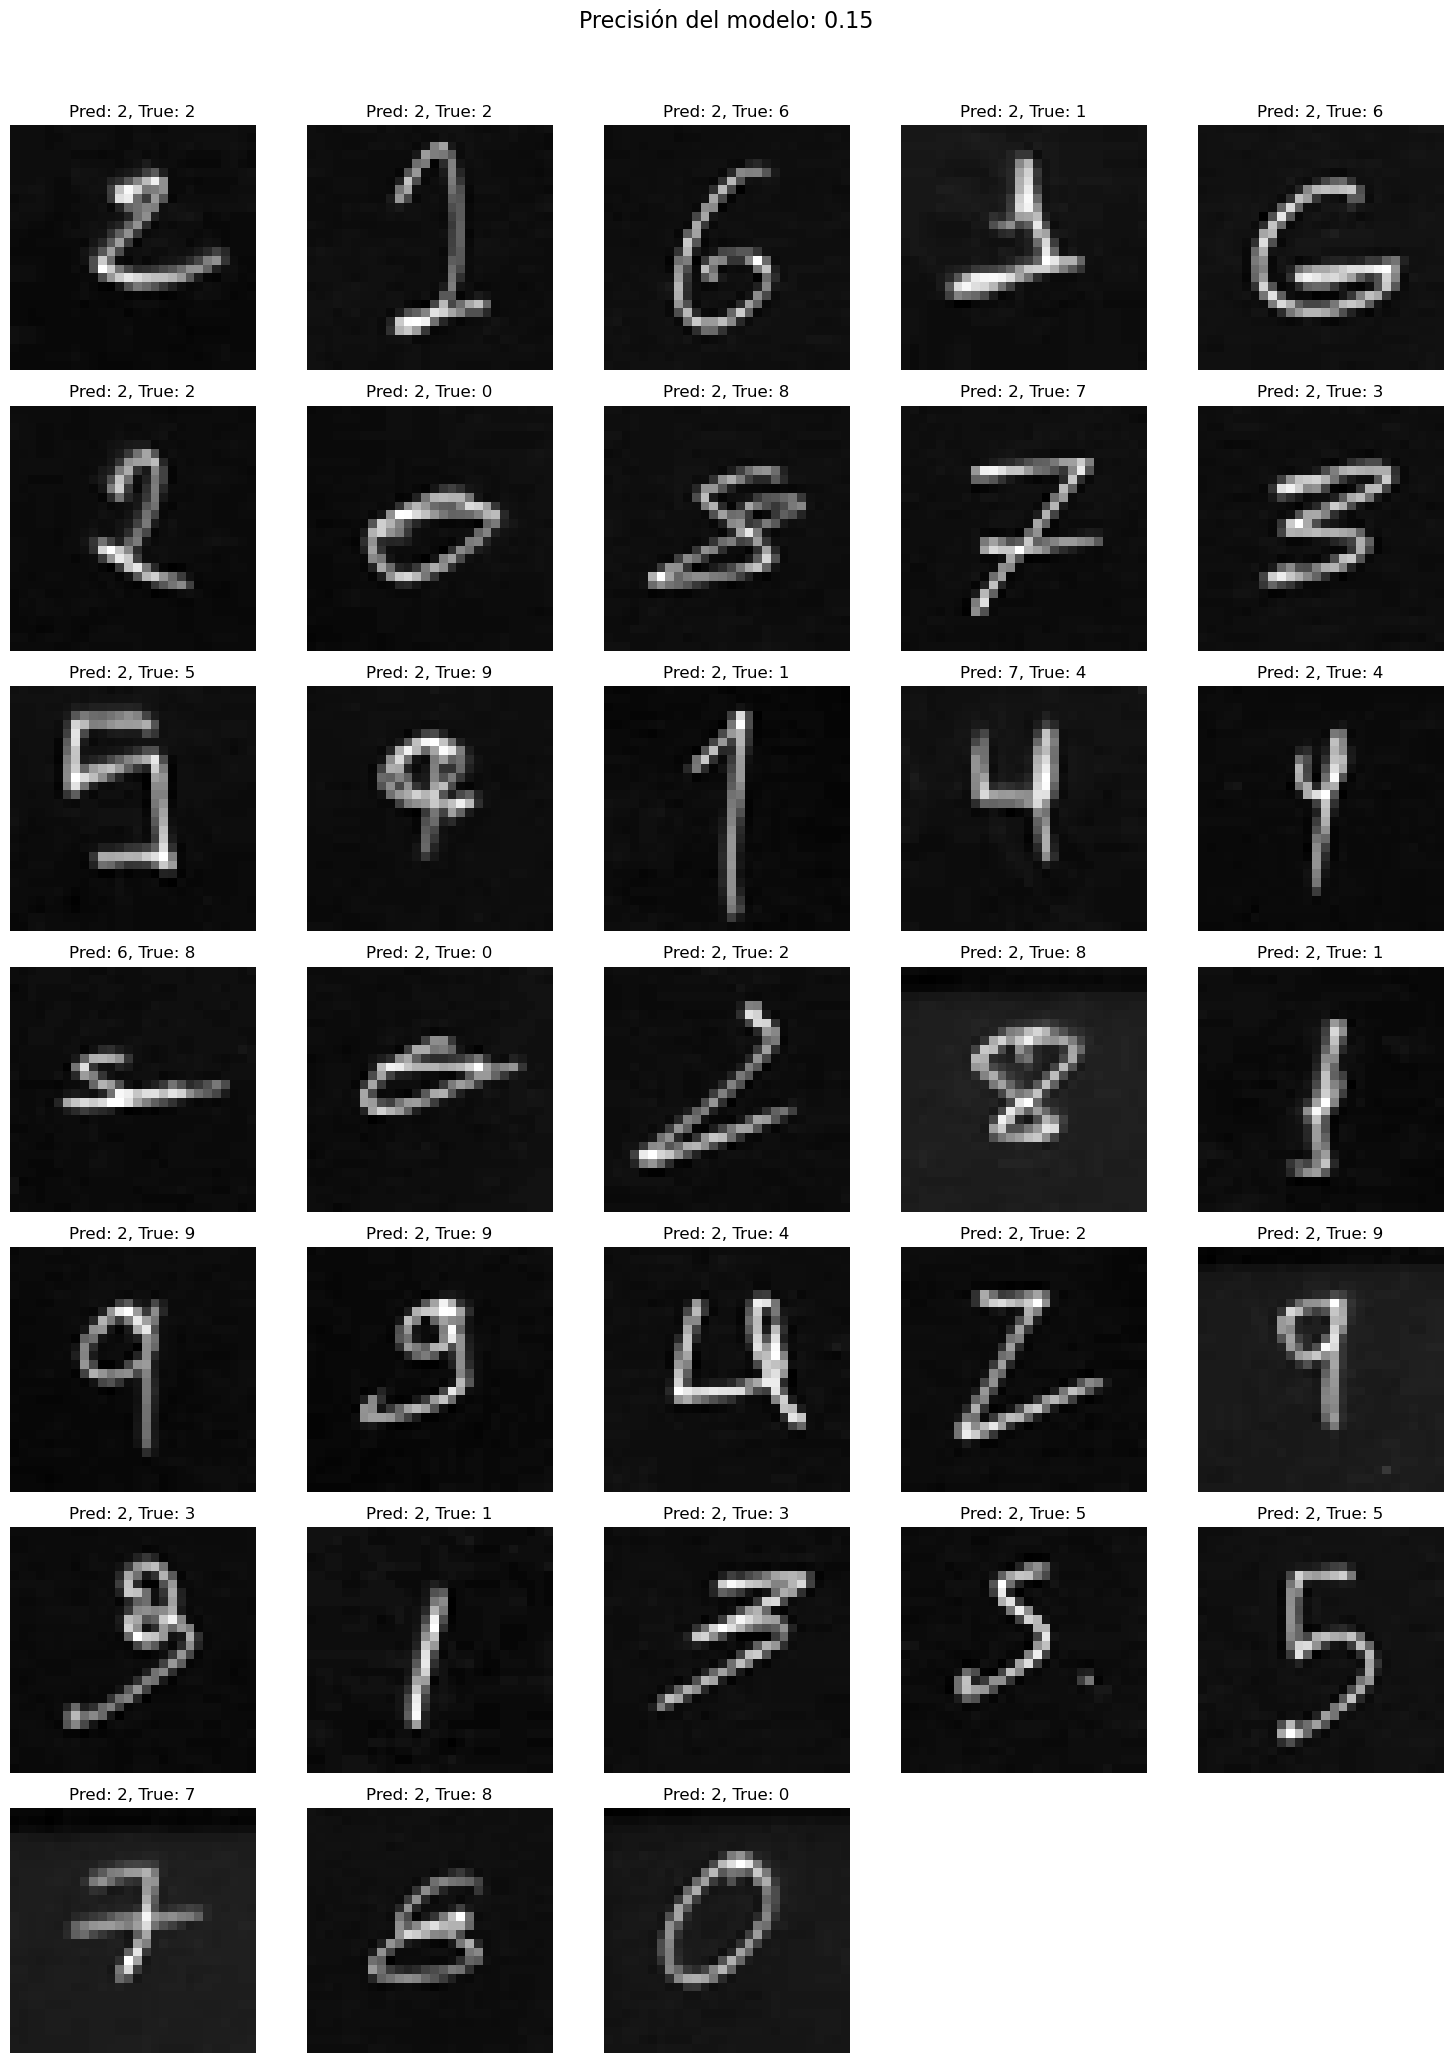

In [137]:
# Realizar inferencia en múltiples imágenes
img_folder = 'img/new_digits'
make_inference(model, img_folder, true_labels, device)

Como vemos, el modelo no es tan bueno a la hora de generalizar. Esto puede deberse a varios motivos:

- **Sesgo en el conjunto de entrenamiento**: El modelo podría tener sesgos hacia ciertos dígitos debido a una distribución no uniforme de los datos de cada clase. En este caso, podemos descartar este punto, porque tanto las visualizaciones previas de los datos, como el análisis de su desempeño muestran que no parece tener preferencia hacia ninguna clase en particular.
- **Falta de representación de variabilidad**: El conjunto de datos de entrenamiento podría no representar correctamente la variabilidad de formas y estilos de escritura, llevando a una falta de robustez. Esta opción también podríamos descartarla en principio, porque nuestras visualizaciones han demostrado que el conjunto de datos es rico en variedad de estilos y trazos.
- **Mal desempeño del modelo**: Podríamos necesitar revisar la arquitectura del modelo, porque podría no estar capturando del todo bien las características distintivas. Sin embargo, dado su desempeño en el conjunto de validación, me hace pensar que la arquitectura es lo suficientemente sólida como para reconocer esto.
- **Problemas en el pipeline de preprocesamiento** - Podría ser que tengamos inconsistencias entre el procesamiento de las imágenes nuevas y las del conjunto de datos original. Conviene revisar nuestras capas de preprocesamiento para verificar que todo esté en orden.
- **Ruido en las imágenes nuevas**: Las imágenes nuevas podrían tener ruido o artefactos que no se encuentren presentes en el conjunto de datos MNIST. Esta diría que es la opción más probable en este caso, veremos los motivos a continuación.

### 6.1. Exploración del problema más a fondo

Si miramos más detenidamente las imágenes, podemos ver a simple vista algo interesante. A diferencia de las imágenes del conjunto de datos MNIST, las imágenes creadas por mi tienen una menor solidez en el valor de sus pixeles, tanto para el trazo como para en fondo.

En los análisis previos, pudimos ver que la distribución de los pixeles era clara; La mayor parte de los pixeles tienen un valos de 0, que corresponde al fondo negro, con un pico secundario en el valor 255, que corresponde al trazo. La distribución tendía mayoritariamente a estos valores, teniendo una cantidad mínima de valores de escala de grises intermedios, que correspondían principalmente a los pixeles colindantes al trazo principa.

En cambio, en este nuevo conjunto de imágenes, podemos ver como el negro del fondo realmente no es tan negro, y el trazo blanco no es tan sólido, ambos corresponden a una escala de grises más oscuros o claros.

Para ver esto de una forma más clara, recordemos el historigrama que vimos previamente:

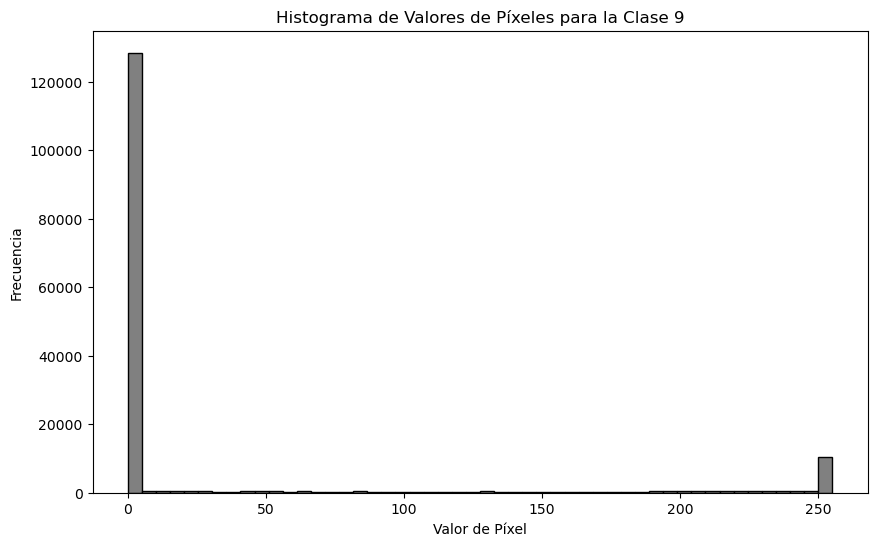

In [121]:
show_pixel_hist(train_path, 9)

Ahora visualicemos el histograma de los valores de los pixeles en las nuevas imágenes.

In [138]:
def visualize_histogram(images_folder):
    """
    Preprocesa las imágenes en una carpeta y muestra la distribución de los valores de los píxeles en un histogra.

    Args:
    images_folder (str): Ruta a la carpeta con las imágenes para el preprocesamiento.
    """
    _, images_paths = preprocess_images_in_folder(images_folder)
    pixel_values = []

    for image_path in images_paths:
        image = Image.open(image_path).convert('L')
        image = image.resize((28, 28))
        image = np.array(image)
        image = 255 - image
        pixel_values.extend(image.flatten())
    
    # Mostrar el histograma de la distribución de los valores de píxeles
    plt.figure(figsize=(10, 6))
    plt.hist(pixel_values, bins=50, color='gray', edgecolor='black')
    plt.title('Distribución de Valores de Píxeles en Nuevas Imágenes')
    plt.xlabel('Valor de Píxel')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

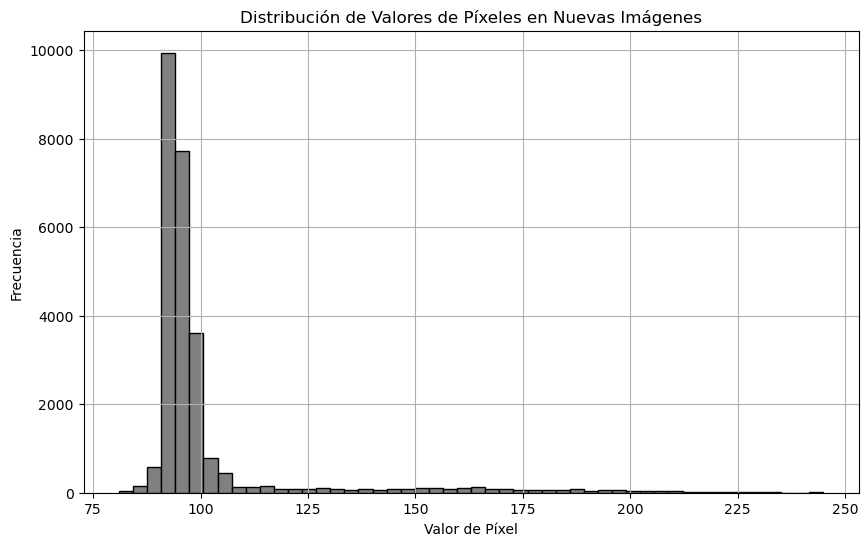

In [148]:
visualize_histogram(img_folder)

Aquí podemos ver que, efectivamente, la distribución de los pixeles ocupa un área de escala de grises más amplia.

Para ver si el problema viene de aquí, vamos a probar a establecer un umbral, que reducirá el valor de los pixeles por debajo de un valor determinado a 0 (haciendo que tenga un color negro) y los pixeles por encima de un valor determinado a 255 (haciendo que tengan un color blanco).

Este umbral vamos a introducirlo modificando la función de preprocesamiento.

In [156]:
def preprocess_image(image_path, lower_threshold=50, upper_threshold=150):
    """
    Carga y preprocesa una imagen.

    Args:
    image_path (str): Ruta a la imagen para el preprocesamiento.

    Returns:
    torch.Tensor: Imagen preprocesada.
    """
    image = Image.open(image_path).convert('L')  # Convertir a escala de grises
    image = image.resize((28, 28))  # Redimensionar a 28x28
    image = np.array(image)  # Convertir a array de numpy
    image = 255 - image  # Invertir colores (MNIST es fondo negro y dígitos blancos)
    image = (image - image.min()) / (image.max() - image.min()) * 255  # Normalizar a rango [0, 255]

     # Aplicar umbrales
    image[image < lower_threshold] = 0
    image[image > upper_threshold] = 255
    
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Convertir a tensor y agregar dimensiones
    
    return image

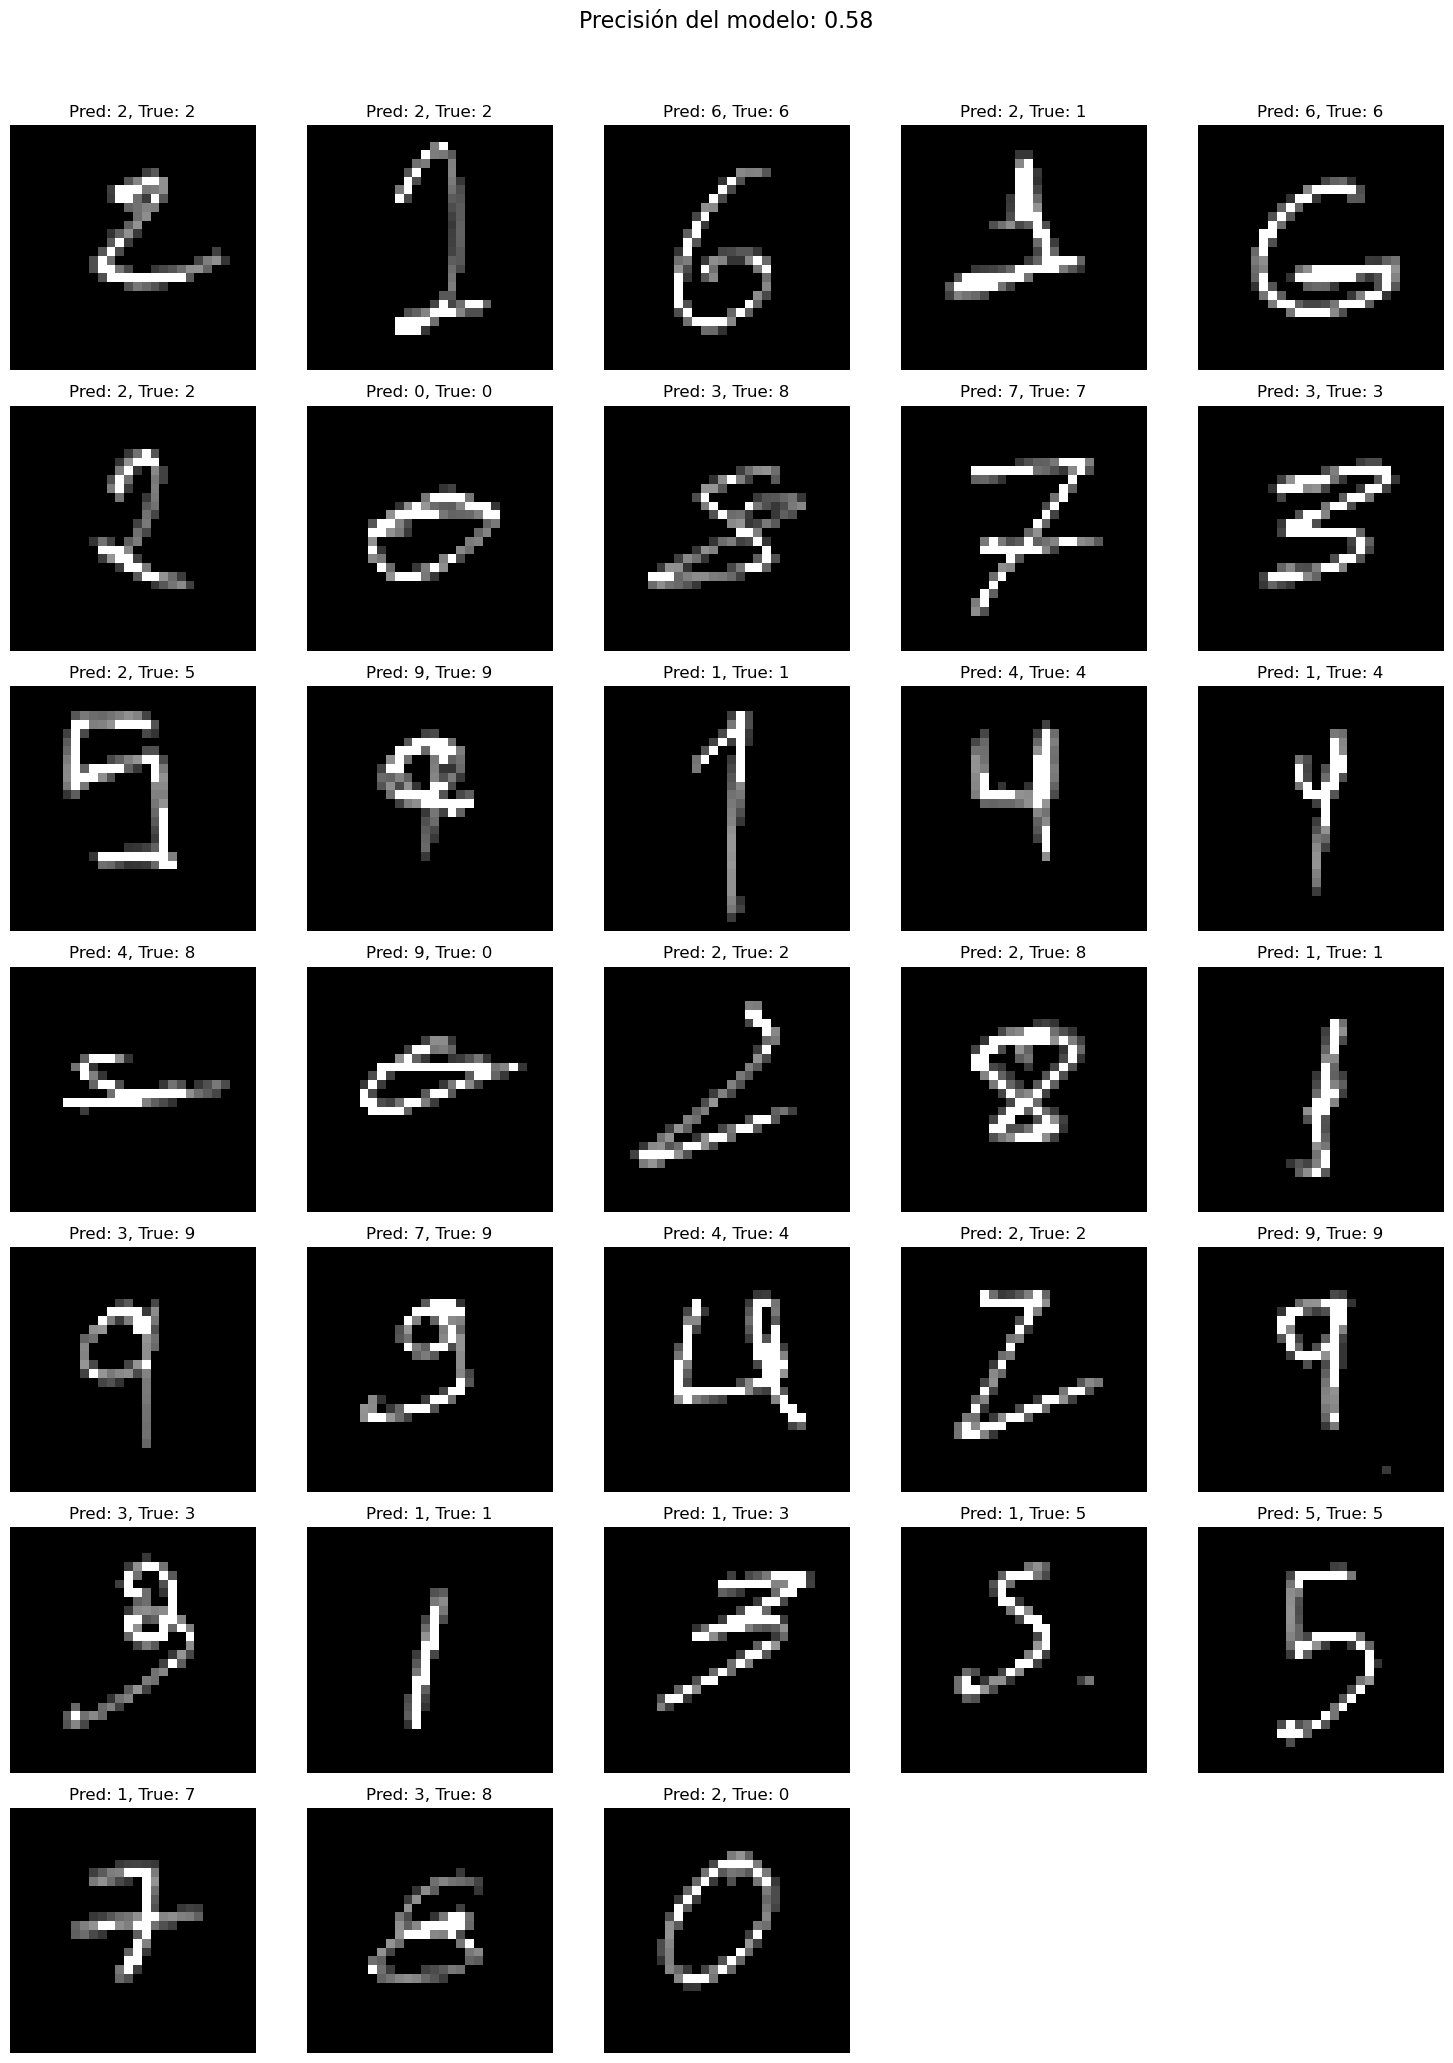

In [157]:
# Realizar inferencia 
make_inference(model, img_folder, true_labels, device)

## 7. Conclusiones finales

Al final, podemos ver como el desempeño de nuestro modelo mejora a medida que acercamos las imágenes a una distribución similar a las imágenes que el modelo ha visto durante su entrenamiento.

Podríamos buscar una forma de crear una capa de normalización que prepare las imágenes nuevas lo máximo posible, buscando los mejores valores representativos para los pixeles y los umbrales, entre otros retoques, para eliminar ruido y solidificar el trazo. Sin embargo, por el momento vamos a dejarlo así.

Como podemos apreciar, las visualizaciones y exploraciones de los datos son puntos clave en nuestros proyectos. Incluso en los casos en los que creemos que a simple vista tenemos contexto de sobra de los datos y los conocemos bien, siempre hay detalles o consideraciones que podemos pasar por alto.

Como humanos, tenemos sesgos, y uno de los que más influyen en nuestra capacidad de conseguir buenos resultados es que tendemos a asumir que sabemos más de lo que realmente sabemos.

Con un buen proceso de exploración de los datos, es mucho más sencillo que veamos qué está causando los problemas que puedan venir más adelante en el proyecto. En este caso, hemos visto esto claramente, al visualizar la distribución de los valores de los pixeles y su influencia en el desempeño del modelo.

A simple vista, podemos distinguir ambos tipos de imágenes bastante bien, tanto las imágenes de MNIST originales como las creadas por mi a mano, sin embargo, si lo que ha visto el modelo en su entrenamiento han sido imágenes con un fondo negro sólido y un trazo blanco sólido, las imágenes con escalas de grises intermedias se vuelven confusas.

Por esto, es importante que los datos sobre los que entrene nuestro modelo sean lo más parecidos posible a los que vaya a ver durante el despliegue, o corremos el riesgo de vernos en situaciones similares, en la que un modelo con un gran desempeño en nuestros experimentos controlados, a la hora de la verdad parece que está adivinando de manera aleatoria.

Otro buen enfoque para controlar este tipo de situaciones, es ejecutar data augmentation durante el preprocesamiento de los datos. De este modo aplicamos transformaciones en los datos, retocando su contraste, brillo, tamaño, forma, orientación, etc. Haciendo entender al modelo que un 7 siempre es un 7, no solo cuando está centrado y con las condiciones de contraste perfectas, sino en muchos otros escenarios posibles. Este es un buen posible paso a tomar para futuras exploraciones.
